<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/qlbm_cfd_plotter_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit qiskit-aer matplotlib numpy qiskit-ibm-runtime qiskit_experiments

--- Starting Classical Advection-Diffusion Simulation ---
Generating plot: Advected Gaussian at t=0.0 (DPI=200)


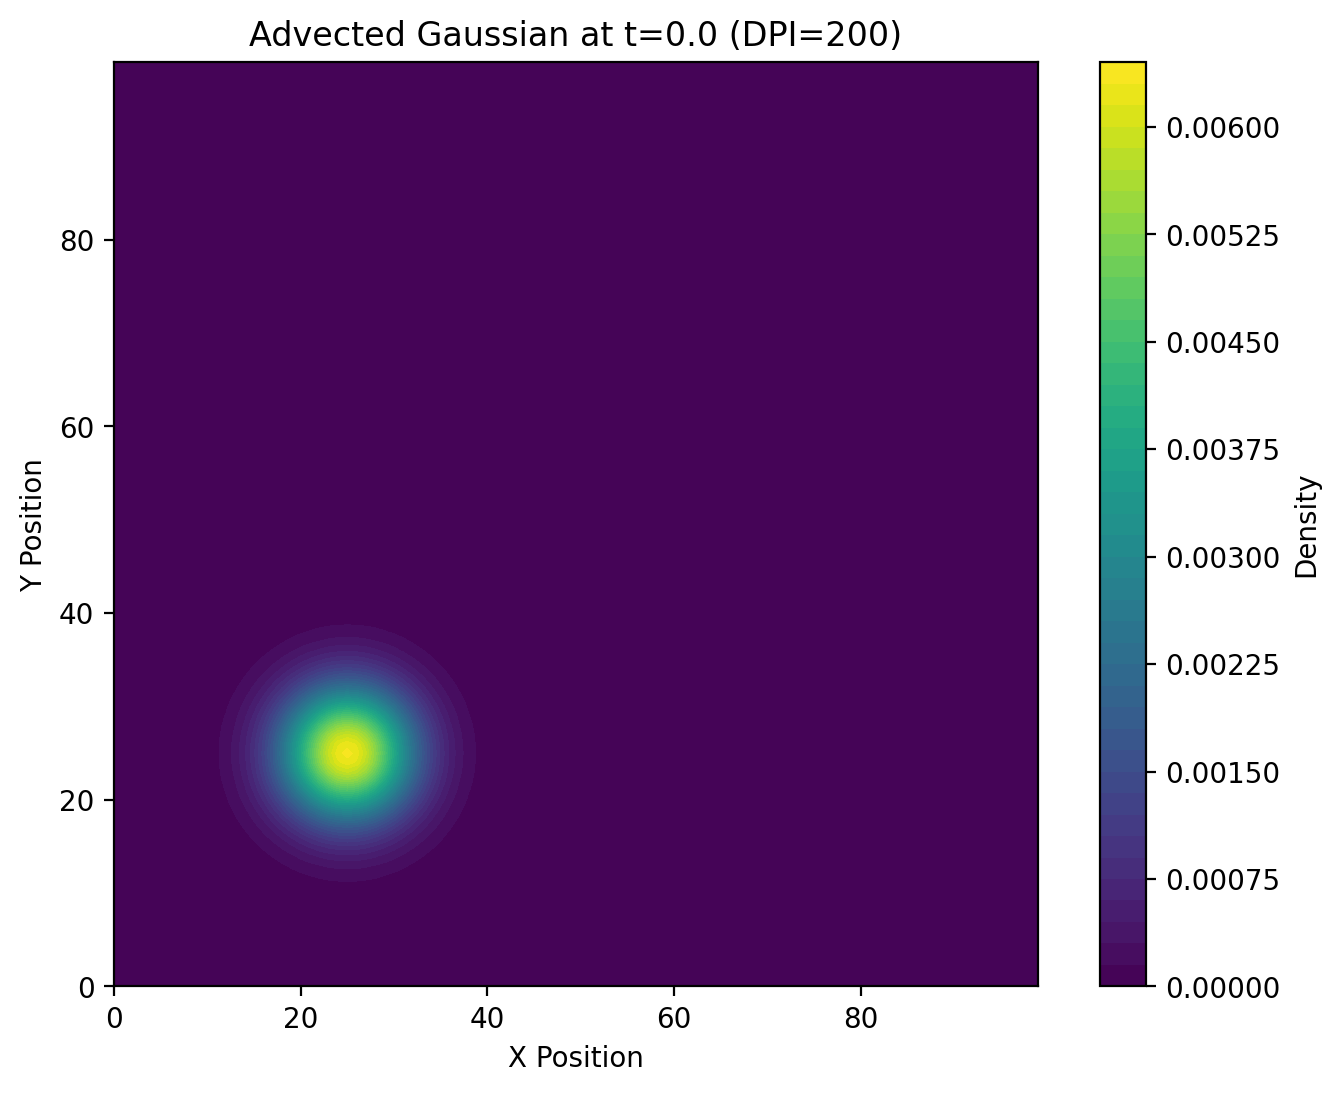

Generating plot: Advected Gaussian at t=12.5 (DPI=200)


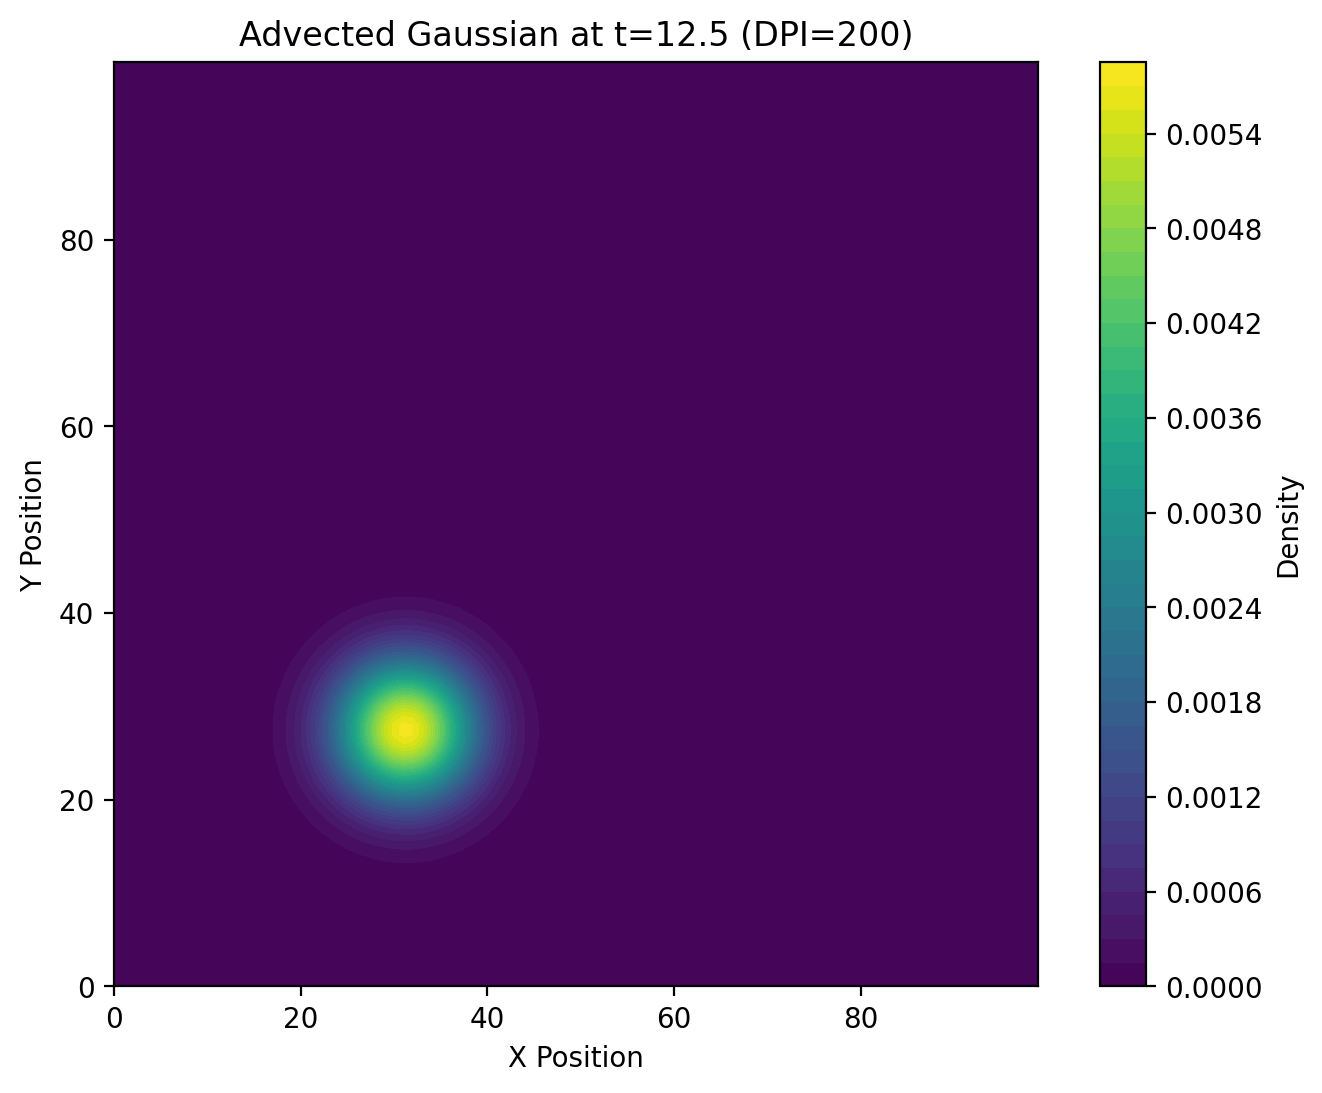

Generating plot: Advected Gaussian at t=25.0 (DPI=200)


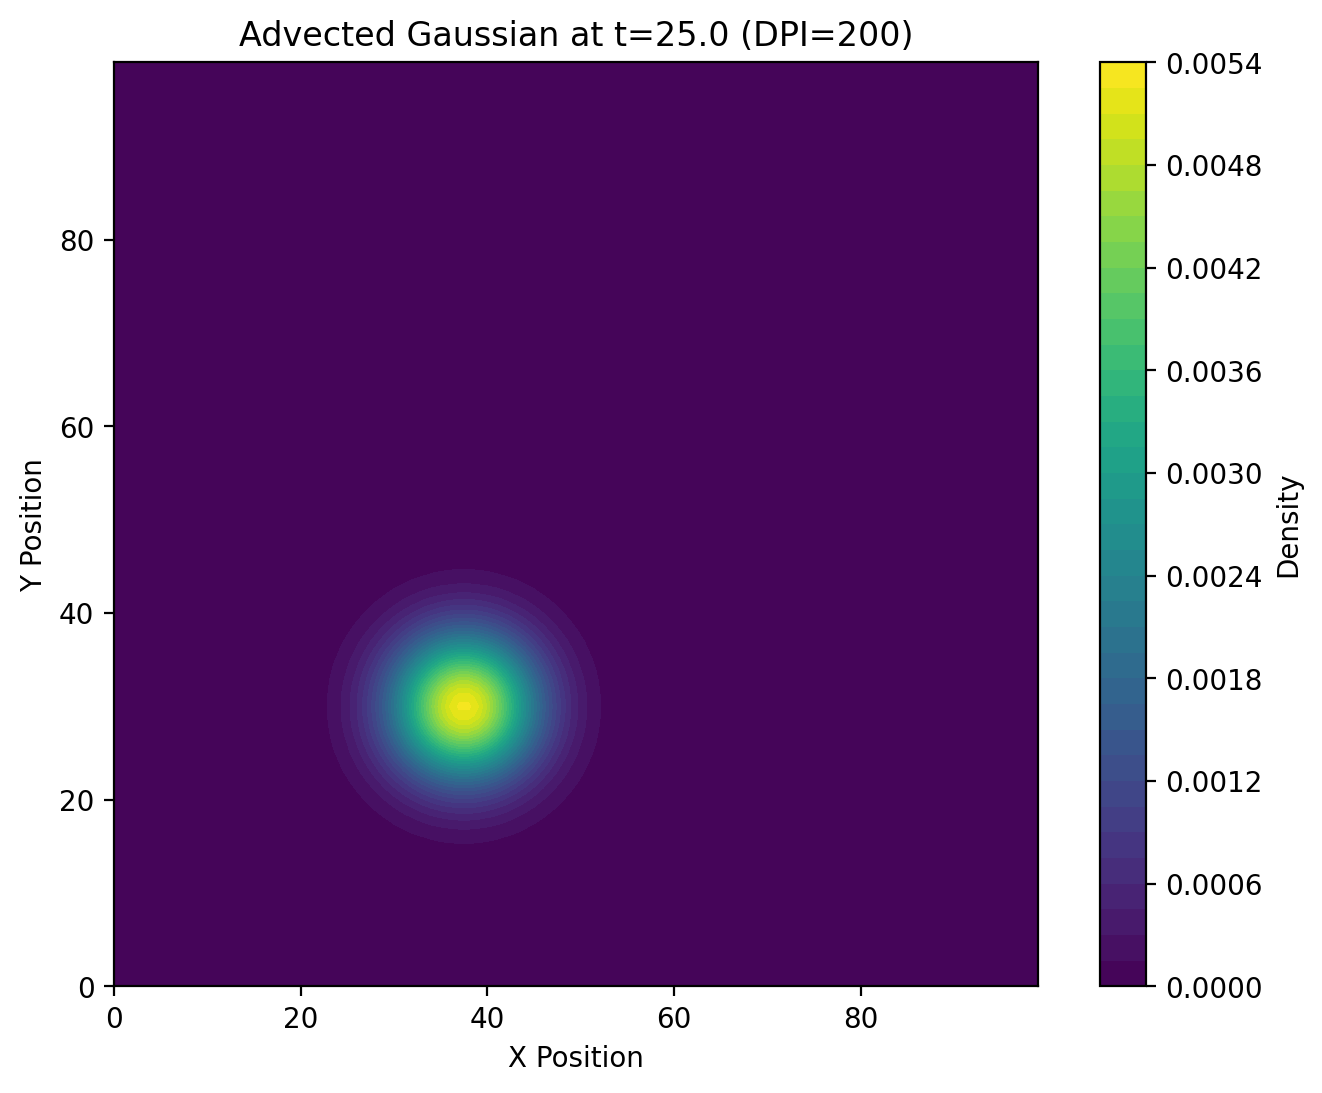

Generating plot: Advected Gaussian at t=37.5 (DPI=200)


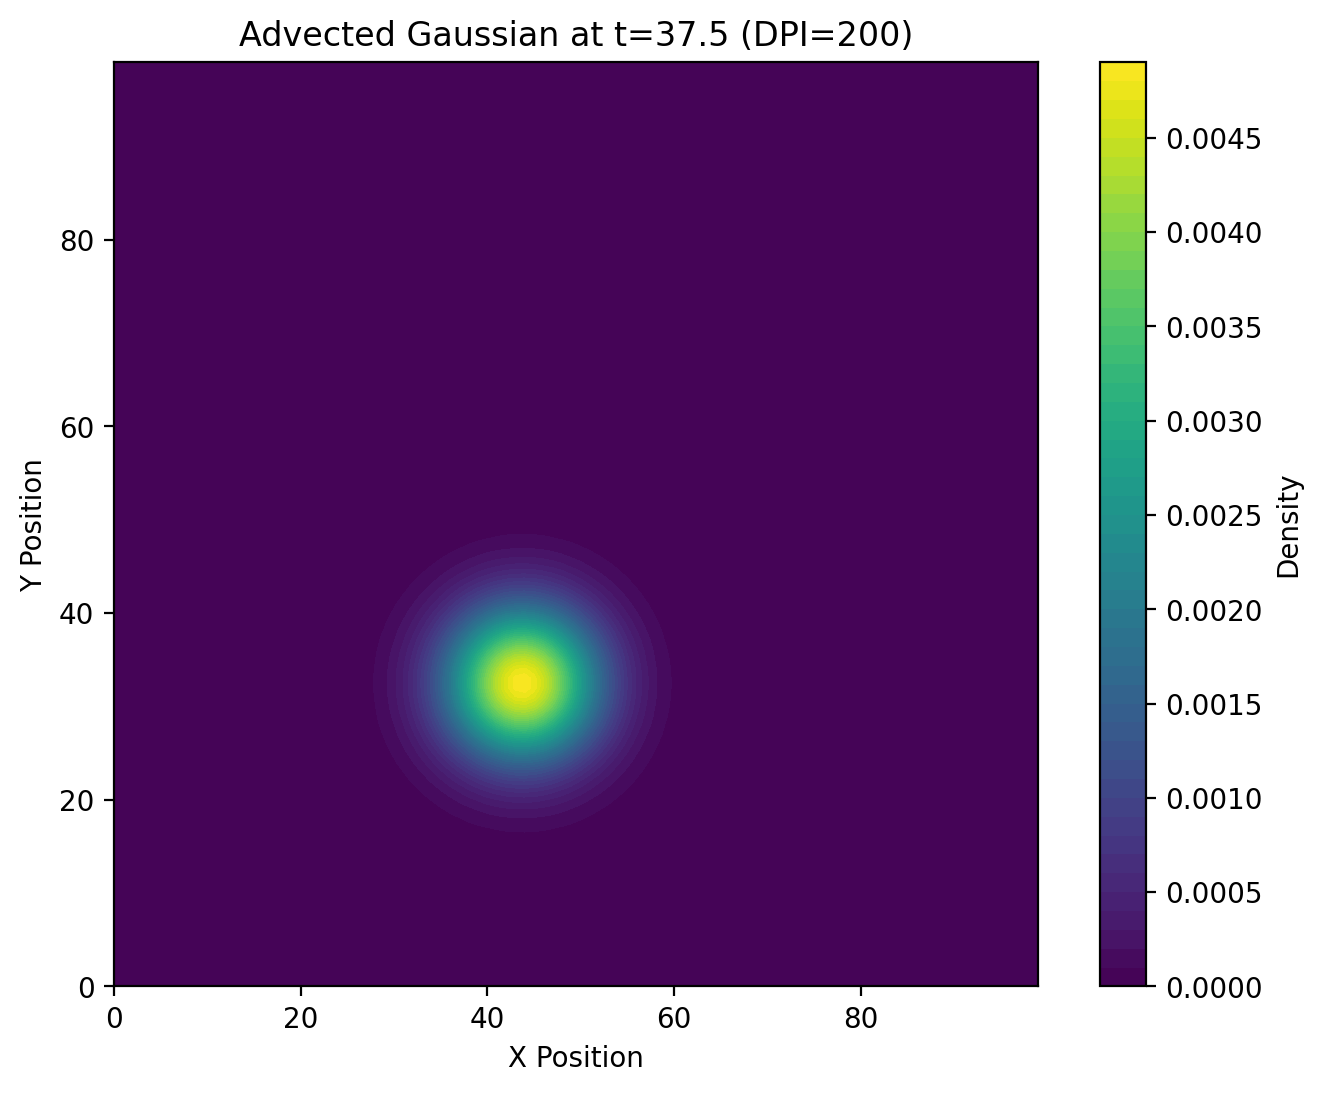

Generating plot: Advected Gaussian at t=50.0 (DPI=200)


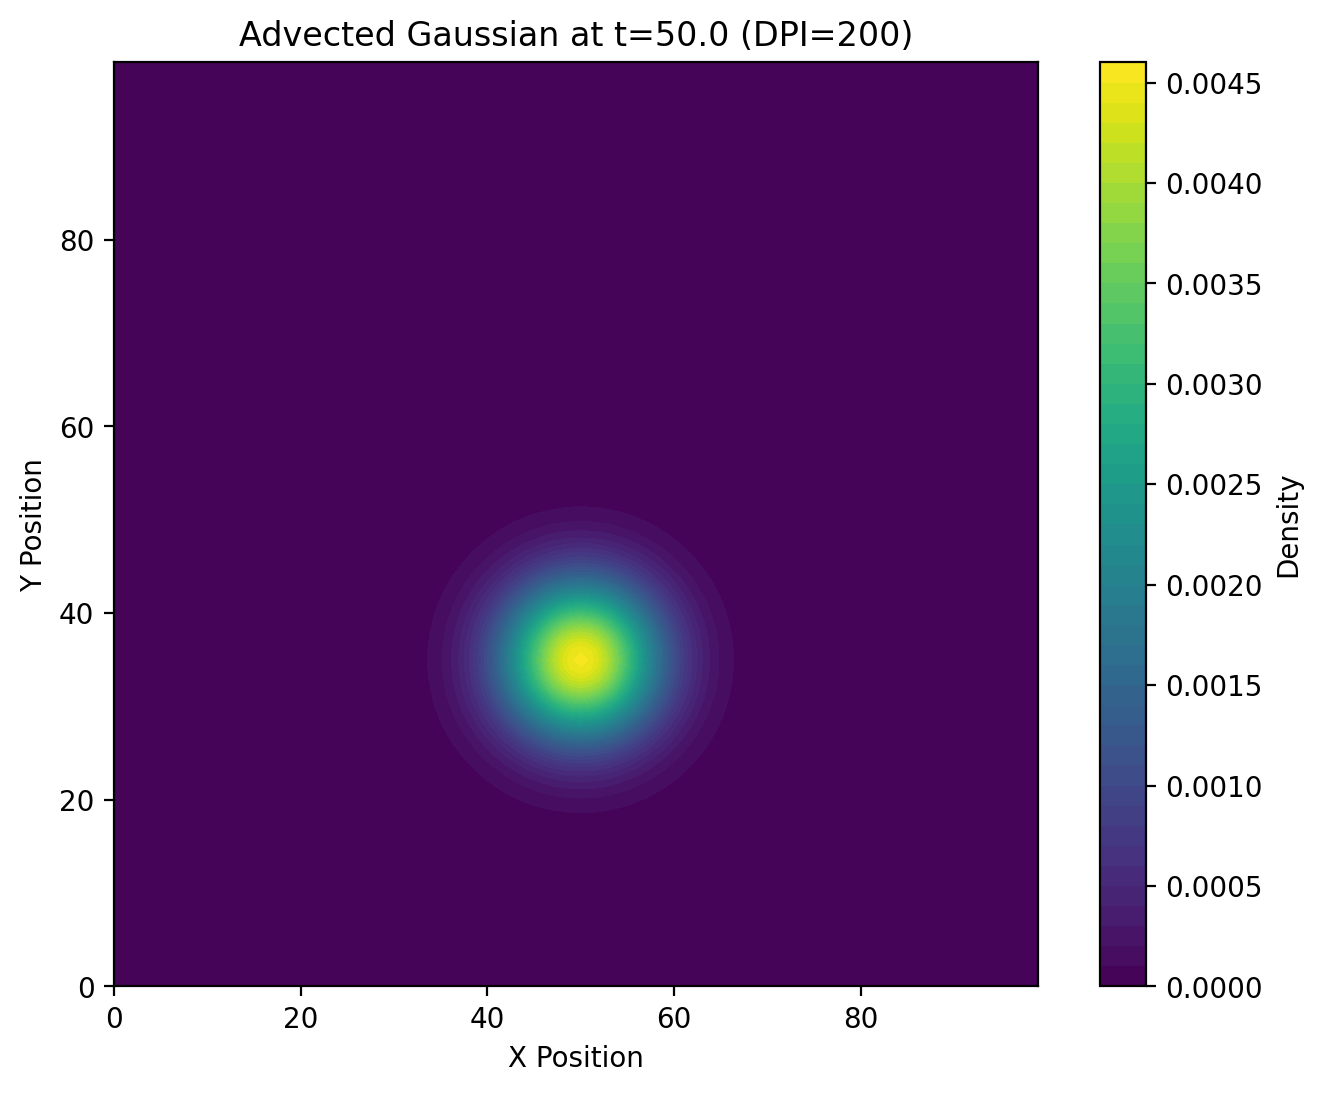


To check 'ibm_marrakesh', uncomment 'check_ibm_backend' in main()
and replace with your IBM Quantum API token.


In [3]:
#!/usr/bin/env python3
"""
qlbm_cfd_plotter.py

Demonstrates CFD contour plotting and IBM Quantum backend inspection.

This script provides a *classical* simulation of 2D advection-diffusion
to generate data for plotting, as running a full QLBM on current
quantum hardware is not yet feasible.

It fulfills the following requirements:
- PEP 8 and PEP 257 compliant.
- Plots 2D contours.
- Uses matplotlib.rcParams to set DPI.
- Includes a function to connect to Qiskit Runtime and inspect
  an IBM Quantum backend (e.g., 'ibm_marrakesh').
"""

import numpy as np
import matplotlib.pyplot as plt

# Try to import Qiskit Runtime, but don't fail if it's not installed
# The main simulation doesn't depend on it.
try:
    from qiskit_ibm_runtime import QiskitRuntimeService
    QISKIT_AVAILABLE = True
except ImportError:
    QISKIT_AVAILABLE = False
    print("Warning: 'qiskit-ibm-runtime' not found.")
    print("To check IBM Quantum backends, please install it via:")
    print("pip install qiskit-ibm-runtime")


def generate_gaussian_field(
    nx: int,
    ny: int,
    t: float,
    u_x: float,
    u_y: float,
    d_coeff: float,
    x_0: float,
    y_0: float,
    sigma_0: float = 5.0
) -> np.ndarray:
    """
    Generates an analytically advected 2D Gaussian field.

    This function provides the "ground truth" solution for an
    advection-diffusion equation with a constant velocity field,
    as discussed in the QLBM paper (e.g., Fig. 2).

    Args:
        nx: Number of grid points in x.
        ny: Number of grid points in y.
        t: Current time.
        u_x: Velocity in x.
        u_y: Velocity in y.
        d_coeff: Diffusion coefficient (assumed isotropic).
        x_0: Initial center of Gaussian in x.
        y_0: Initial center of Gaussian in y.
        sigma_0: Initial standard deviation of the Gaussian.

    Returns:
        A 2D numpy array representing the density field.
    """
    # Create grid coordinates
    x = np.linspace(0, nx - 1, nx)
    y = np.linspace(0, ny - 1, ny)
    X, Y = np.meshgrid(x, y)

    # Calculate current center due to advection
    current_x = x_0 + u_x * t
    current_y = y_0 + u_y * t

    # Calculate current spread (variance) due to diffusion
    # variance = sigma_0^2 + 2 * D * t
    sigma_sq = (sigma_0**2) + (2 * d_coeff * t)

    # Calculate Gaussian
    exponent = -((X - current_x)**2 / (2 * sigma_sq) +
                 (Y - current_y)**2 / (2 * sigma_sq))
    field = (1 / (2 * np.pi * sigma_sq)) * np.exp(exponent)

    return field


def plot_cfd_contours(
    grid: np.ndarray,
    title: str,
    dpi: int = 200
) -> None:
    """
    Plots 2D CFD contour data using matplotlib.

    Sets the figure DPI using rcParams as requested.

    Args:
        grid: The 2D numpy array to plot.
        title: The title for the plot.
        dpi: The dots-per-inch (DPI) for the figure.
    """
    print(f"Generating plot: {title}")

    # Set DPI using rcParams
    plt.rcParams['figure.dpi'] = dpi

    plt.figure(figsize=(8, 6))

    # Create contour plot
    # 'levels' controls the number of contour lines
    # 'cmap' sets the color map
    contours = plt.contourf(grid, levels=50, cmap='viridis')

    # Add a color bar to show the density scale
    plt.colorbar(contours, label='Density')

    plt.title(title)
    plt.xlabel("X Position")
    plt.ylabel("Y Position")

    # Ensure aspect ratio is equal
    plt.gca().set_aspect('equal', adjustable='box')

    # Save or show the plot
    # plt.savefig(f"{title.replace(' ', '_').lower()}.png")
    plt.show()

    # Close the plot to free memory
    plt.close()


def check_ibm_backend(api_token: str, backend_name: str) -> None:
    """
    Connects to IBM Quantum and prints a backend's properties.

    Args:
        api_token: Your IBM Quantum API token.
        backend_name: The name of the backend to check (e.g.,
                      "ibm_marrakesh" or "ibm_torino").
    """
    if not QISKIT_AVAILABLE:
        print("\nQiskit is not installed. Cannot check backend.")
        return

    print(f"\n--- IBM Quantum Backend Check: {backend_name} ---")
    try:
        # Initialize the service
        # You may need to save your token first:
        # QiskitRuntimeService.save_account(channel="ibm_quantum", token=api_token)
        service = QiskitRuntimeService(channel="ibm_quantum", token=api_token)

        # Get the backend
        backend = service.backend(backend_name)

        print(f"Successfully connected to: {backend.name}")
        print(f"  Qubit Count: {backend.num_qubits}")
        print(f"  Basis Gates: {backend.basis_gates}")
        print(f"  Max Circuits: {backend.max_circuits}")

        # Get properties (may take a moment)
        properties = backend.properties()
        if properties:
            # Calculate average CNOT error
            cnot_errors = [
                prop.error
                for prop in properties.gates
                if prop.gate == 'cx'
            ]
            if cnot_errors:
                avg_cnot_error = np.mean(cnot_errors)
                print(f"  Avg. CNOT Error: {avg_cnot_error * 100:.3f}%")

        print(f"\nThis confirms you can connect to '{backend_name}'.")
        print("Note the average CNOT error rate. This is the main")
        print("reason complex algorithms like QLBM are still a")
        print("research challenge on real hardware.")

    except Exception as e:
        print(f"Error connecting to IBM Quantum: {e}")
        print("Please ensure your API token is correct and active,")
        print(f"and that you have access to '{backend_name}'.")
        print("You can get your token from: https://quantum.ibm.com/account")


def main() -> None:
    """
    Main function to run the classical simulation and plot results.
    """
    # --- Simulation Parameters ---
    NX = 100         # Grid size x
    NY = 100         # Grid size y
    TIMESTEPS = 5    # Number of plots to generate
    T_FINAL = 50.0   # Final time

    # Advection velocity
    U_X = 0.5
    U_Y = 0.2

    # Diffusion
    D_COEFF = 0.1

    # Initial state
    X_0 = 25.0
    Y_0 = 25.0

    print("--- Starting Classical Advection-Diffusion Simulation ---")

    for t in np.linspace(0, T_FINAL, TIMESTEPS):
        field = generate_gaussian_field(
            NX, NY, t, U_X, U_Y, D_COEFF, X_0, Y_0
        )
        plot_cfd_contours(
            field,
            f"Advected Gaussian at t={t:.1f} (DPI=200)",
            dpi=200
        )

    # --- IBM Quantum Check ---
    # To run this, uncomment the lines below and paste your API token.
    # api_token = "YOUR_IBM_QUANTUM_API_TOKEN_GOES_HERE"
    # check_ibm_backend(api_token, "ibm_marrakesh")

    # You can get your token from: https://quantum.ibm.com/account
    print("\nTo check 'ibm_marrakesh', uncomment 'check_ibm_backend' in main()")
    print("and replace with your IBM Quantum API token.")


if __name__ == "__main__":
    main()

--- Starting Classical Advection-Diffusion Simulation ---
Generating 3D plot: Advected Gaussian at t=0.0 (DPI=200)


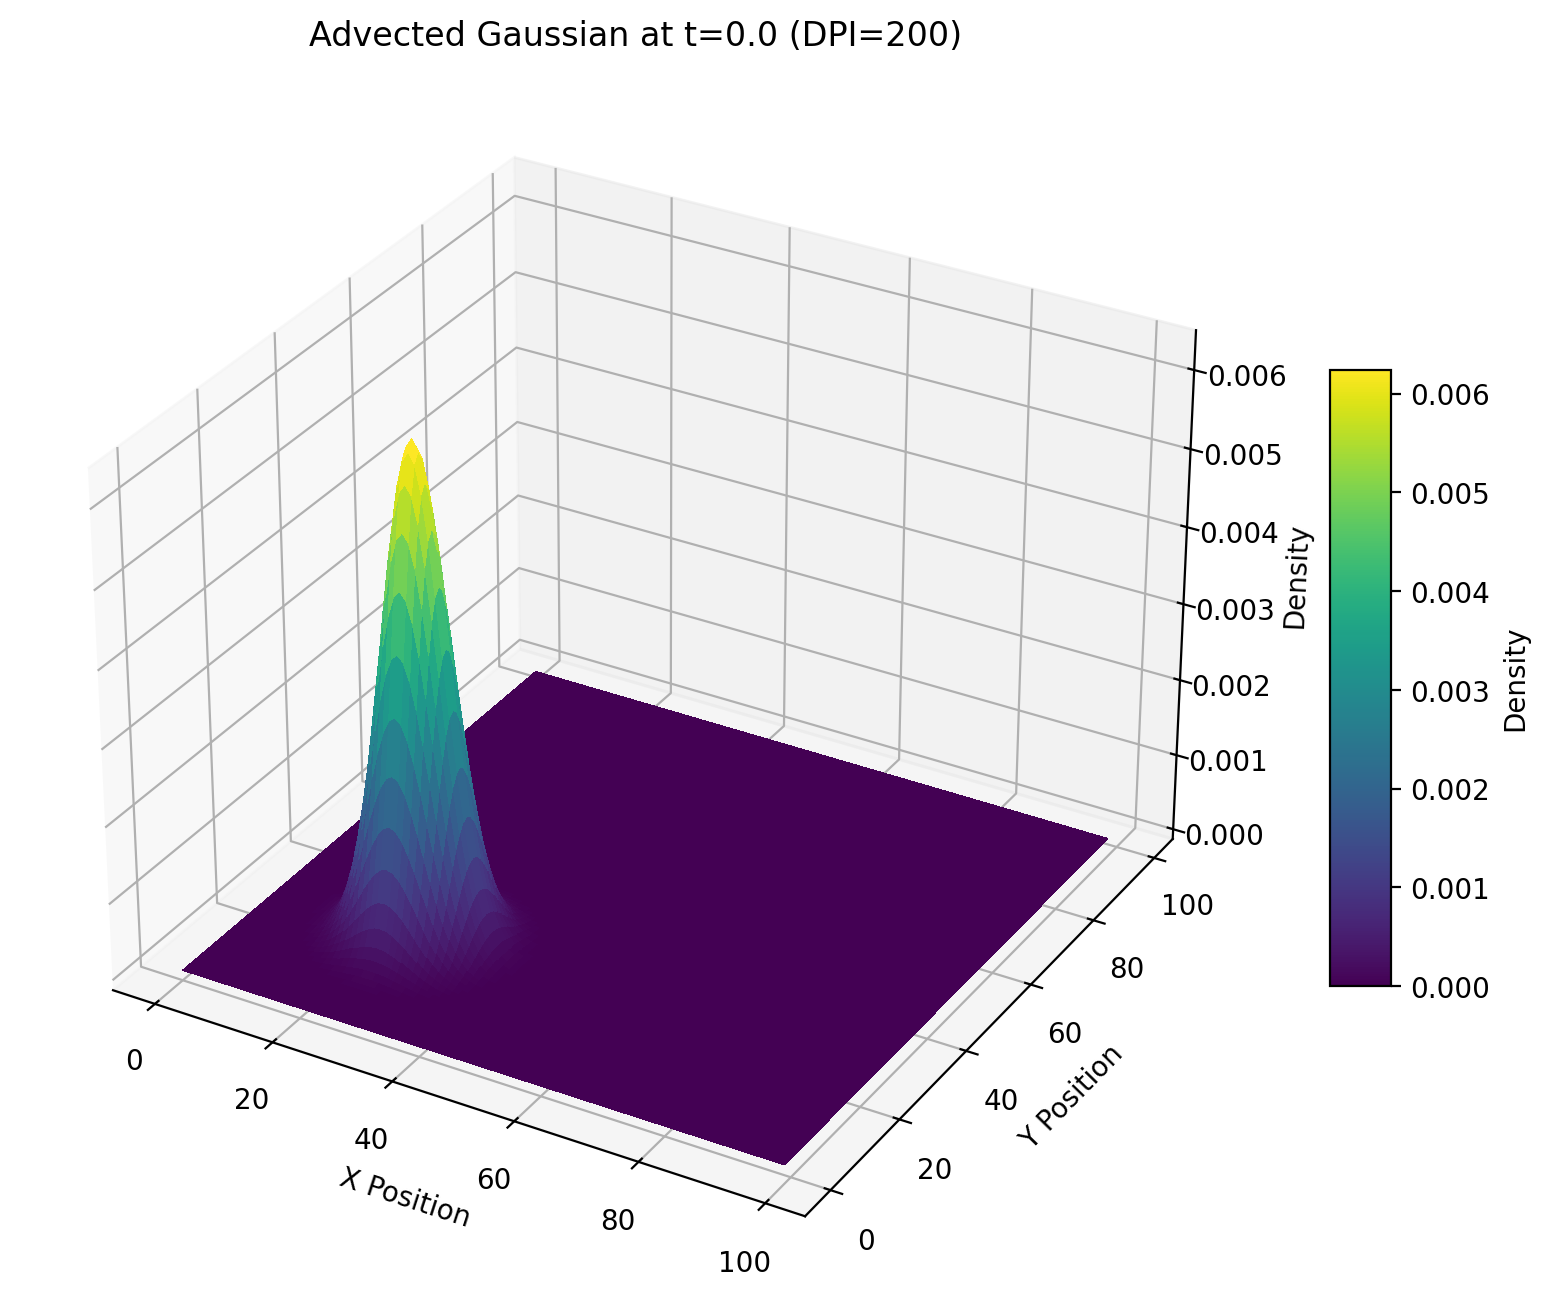

Generating 3D plot: Advected Gaussian at t=12.5 (DPI=200)


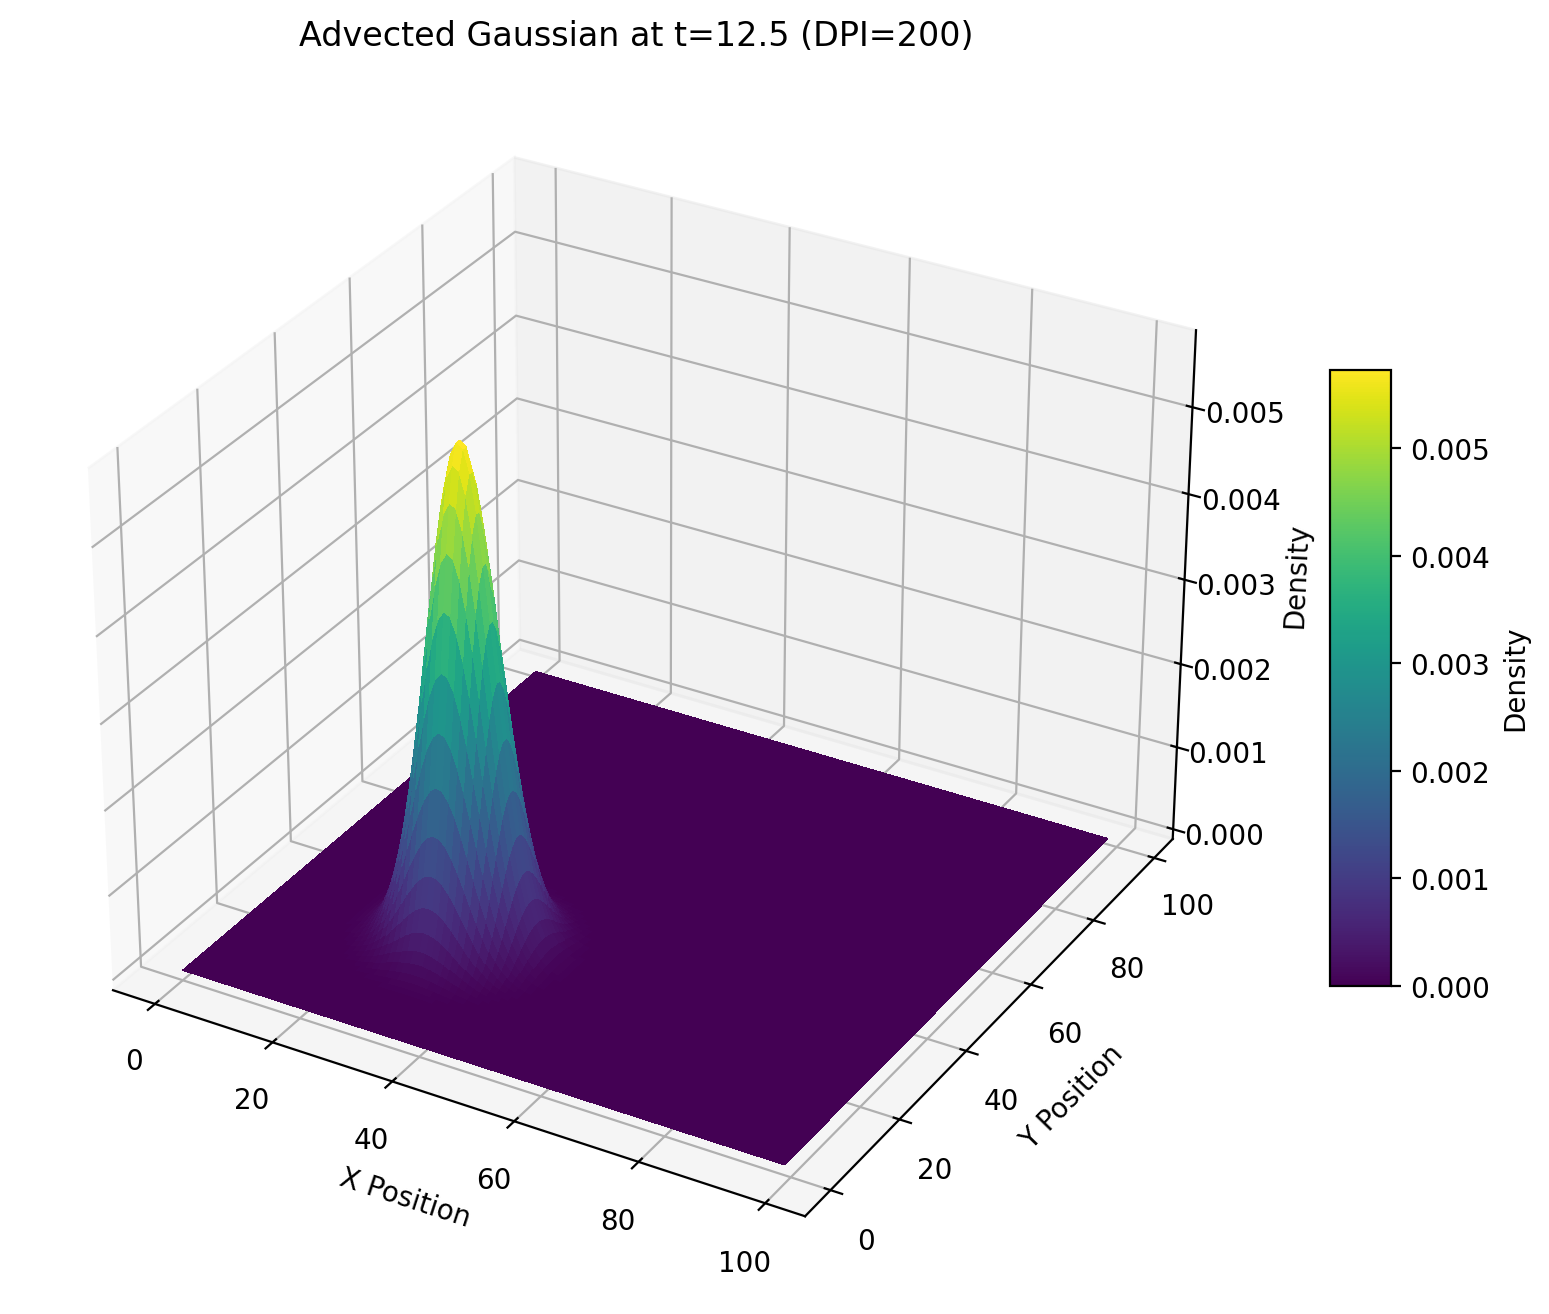

Generating 3D plot: Advected Gaussian at t=25.0 (DPI=200)


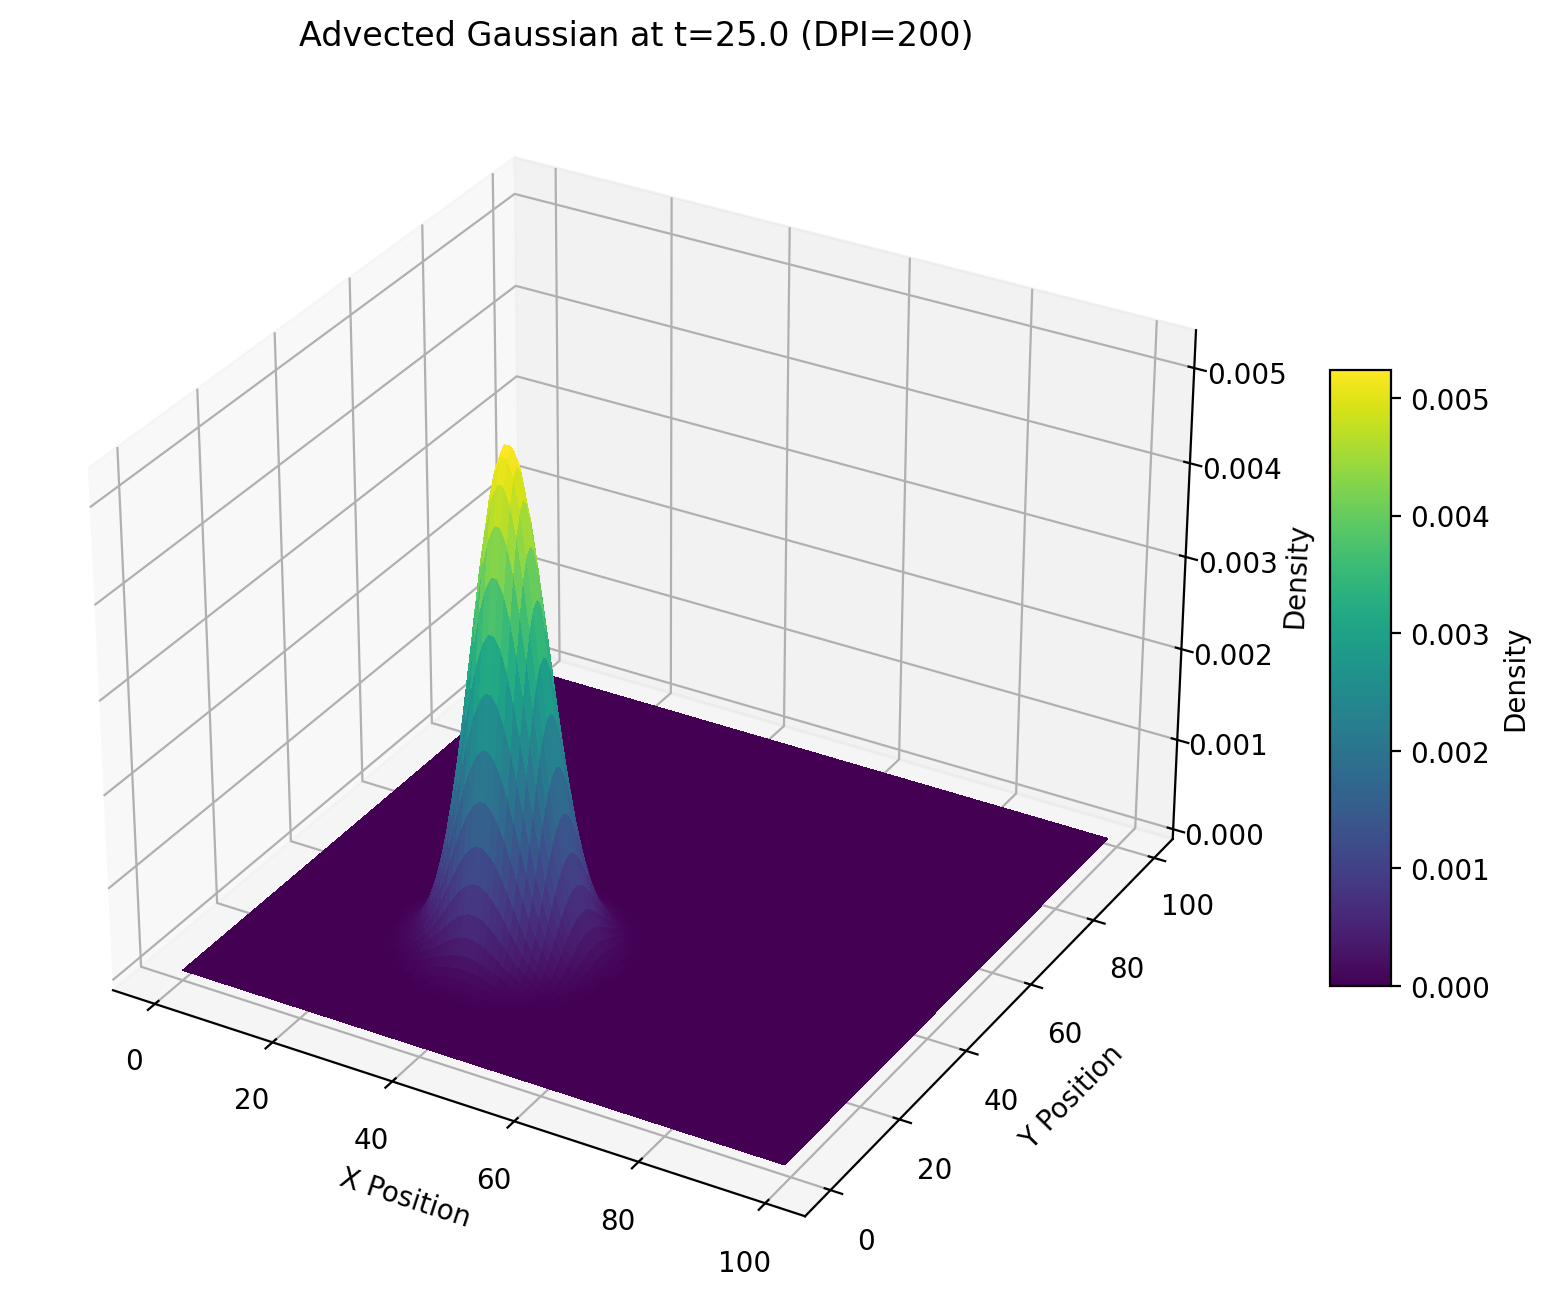

Generating 3D plot: Advected Gaussian at t=37.5 (DPI=200)


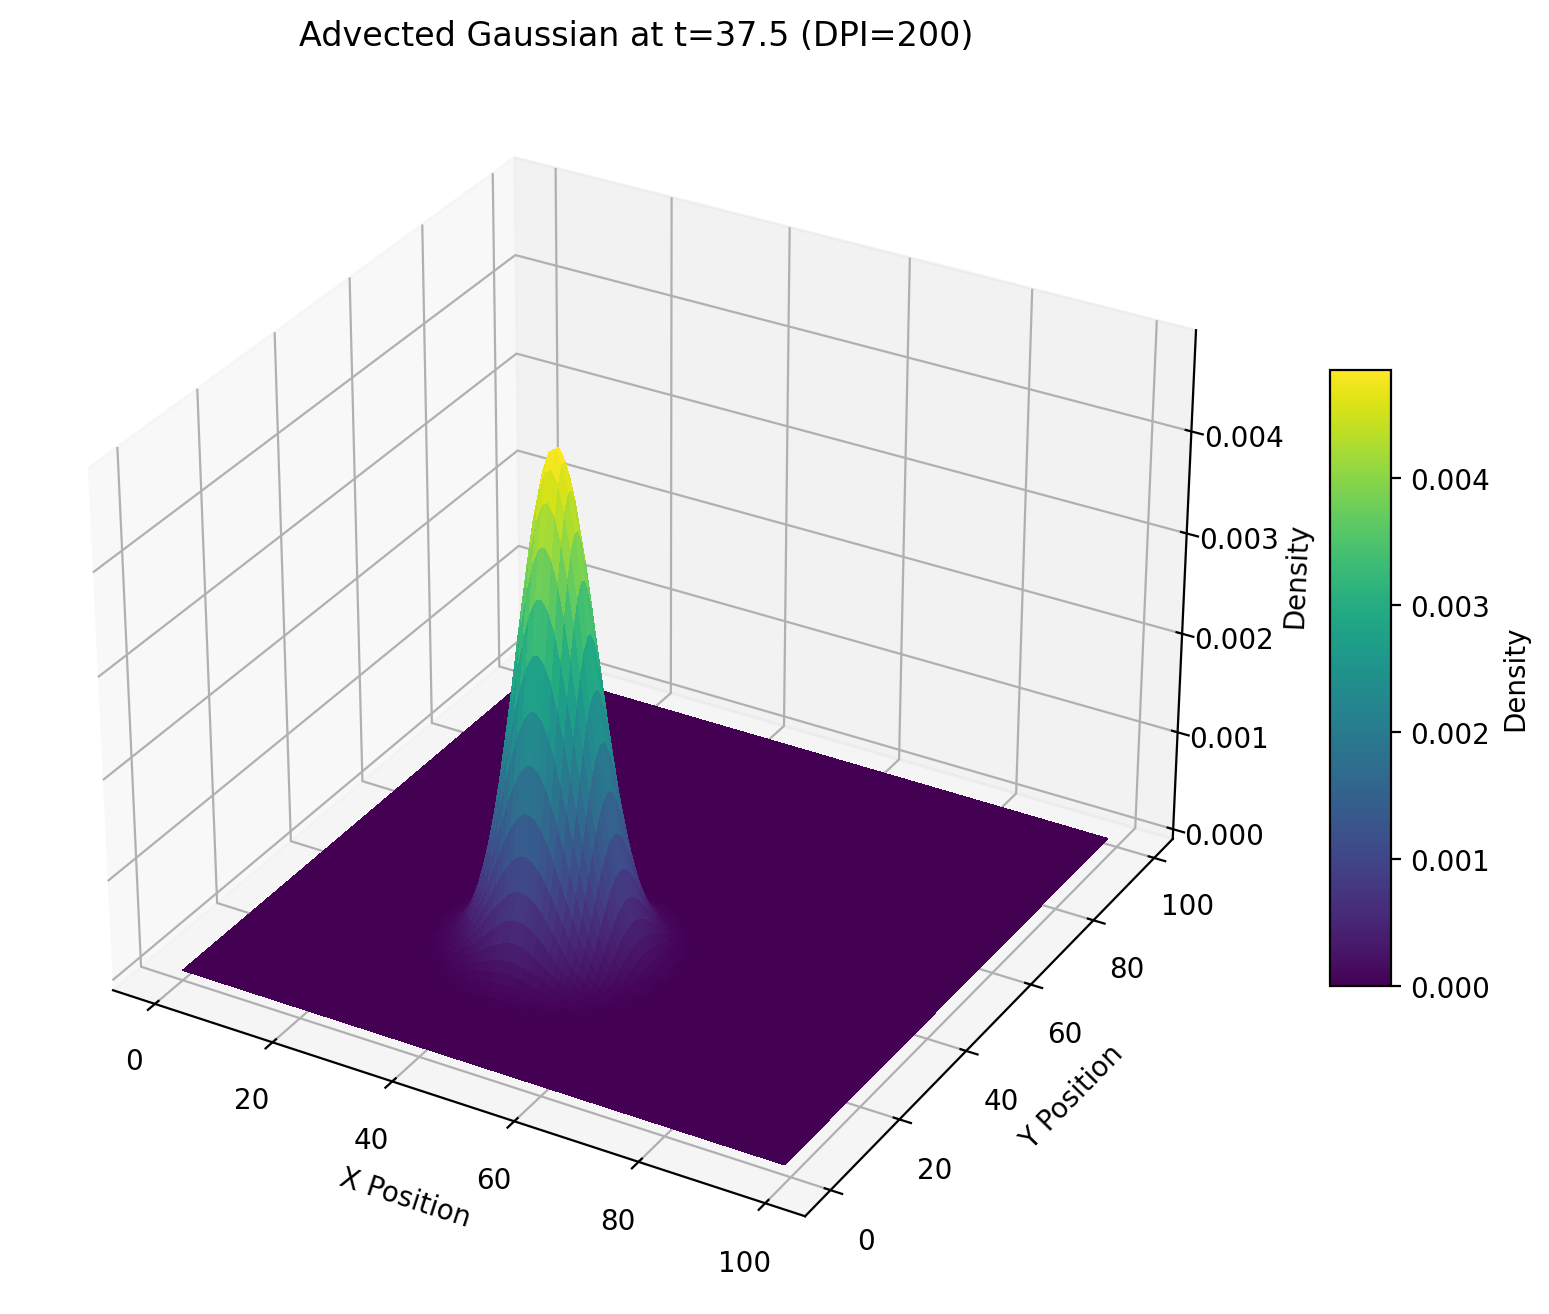

Generating 3D plot: Advected Gaussian at t=50.0 (DPI=200)


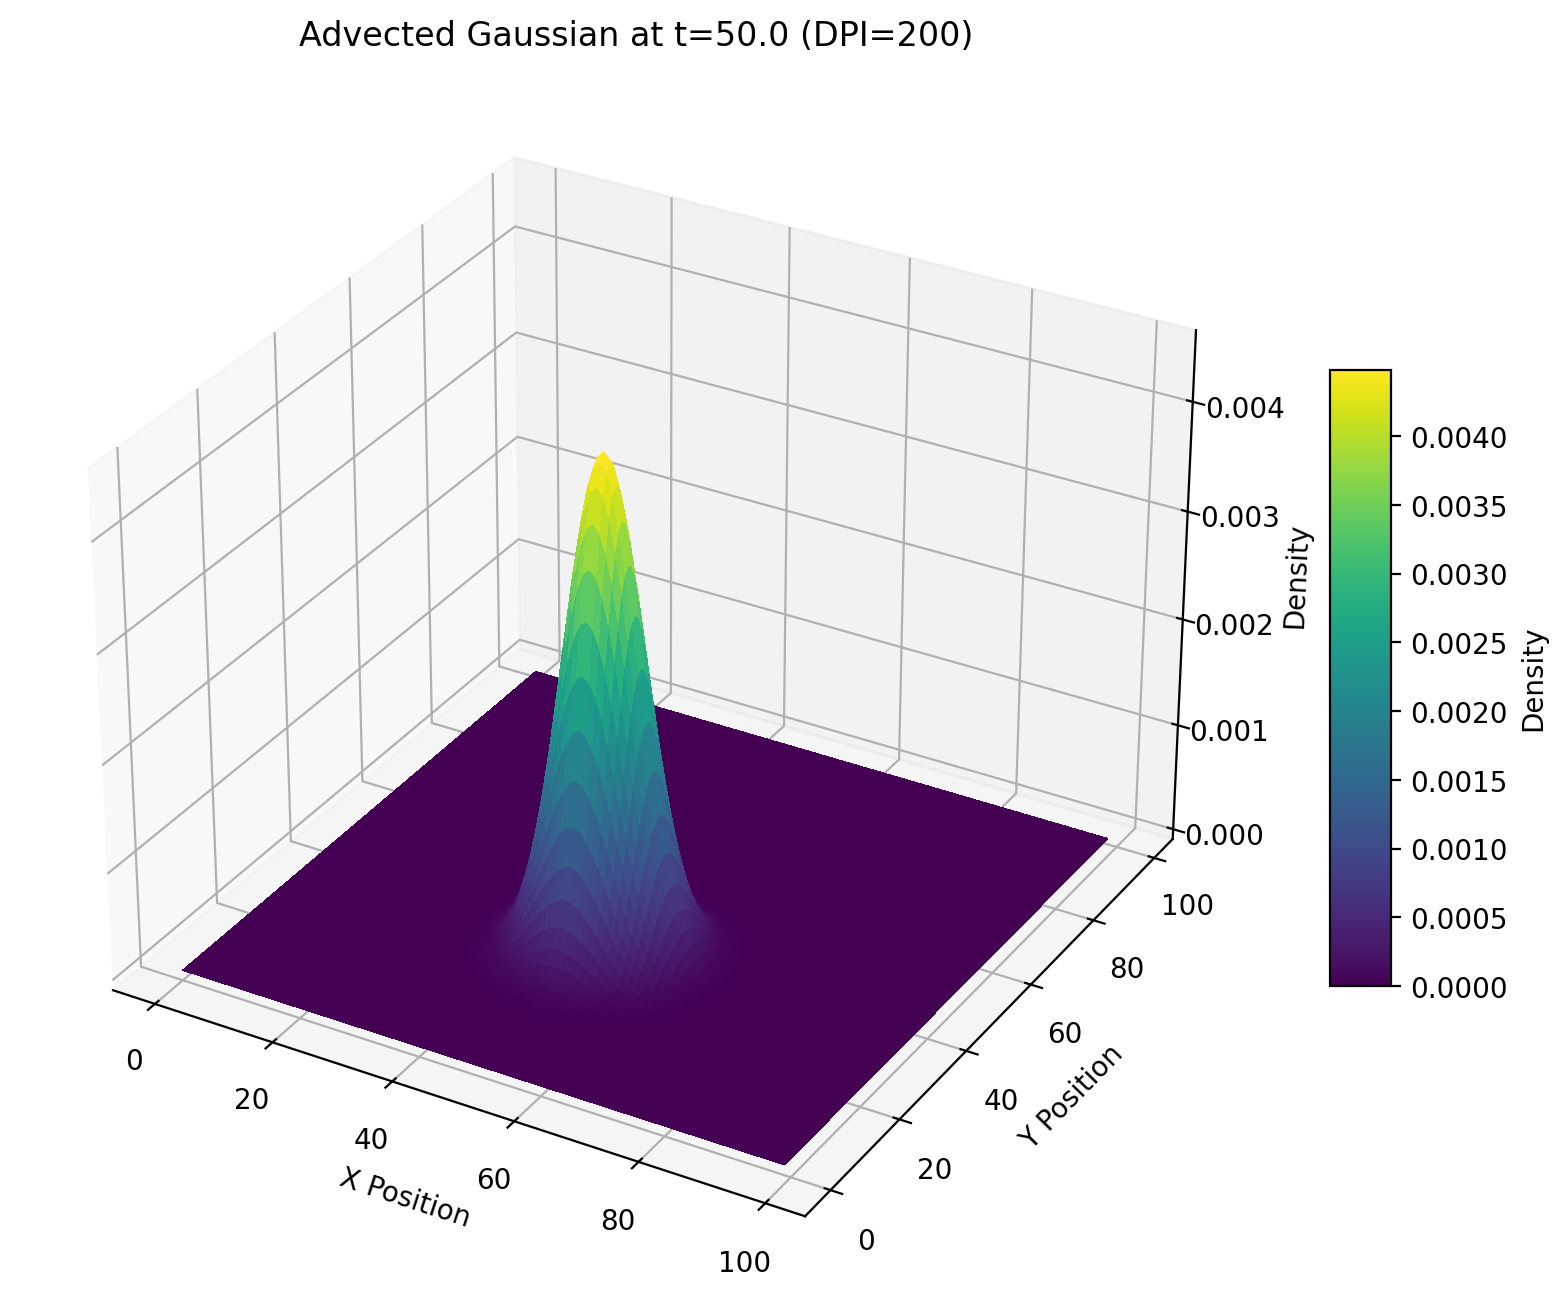


To check 'ibm_marrakesh', uncomment 'check_ibm_backend' in main()
and replace with your IBM Quantum API token.


In [6]:
#!/usr/bin/env python3
"""
qlbm_cfd_plotter_3d.py

Demonstrates 3D CFD surface plotting and IBM Quantum backend inspection.

This script provides a *classical* simulation of 2D advection-diffusion
to generate data for plotting, as running a full QLBM on current
quantum hardware is not yet feasible.

It fulfills the following requirements:
- PEP 8 and PEP 257 compliant.
- Plots 3D surfaces.
- Uses matplotlib.rcParams to set DPI.
- Includes a function to connect to Qiskit Runtime and inspect
  an IBM Quantum backend (e.g., 'ibm_marrakesh').
"""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting

# Try to import Qiskit Runtime, but don't fail if it's not installed
# The main simulation doesn't depend on it.
try:
    from qiskit_ibm_runtime import QiskitRuntimeService
    QISKIT_AVAILABLE = True
except ImportError:
    QISKIT_AVAILABLE = False
    print("Warning: 'qiskit-ibm-runtime' not found.")
    print("To check IBM Quantum backends, please install it via:")
    print("pip install qiskit-ibm-runtime")


def generate_gaussian_field(
    nx: int,
    ny: int,
    t: float,
    u_x: float,
    u_y: float,
    d_coeff: float,
    x_0: float,
    y_0: float,
    sigma_0: float = 5.0
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates an analytically advected 2D Gaussian field.

    This function provides the "ground truth" solution for an
    advection-diffusion equation with a constant velocity field,
    as discussed in the QLBM paper (e.g., Fig. 2).

    Args:
        nx: Number of grid points in x.
        ny: Number of grid points in y.
        t: Current time.
        u_x: Velocity in x.
        u_y: Velocity in y.
        d_coeff: Diffusion coefficient (assumed isotropic).
        x_0: Initial center of Gaussian in x.
        y_0: Initial center of Gaussian in y.
        sigma_0: Initial standard deviation of the Gaussian.

    Returns:
        A tuple (X, Y, field) containing the X and Y meshgrids
        and the 2D numpy array representing the density field (Z).
    """
    # Create grid coordinates
    x = np.linspace(0, nx - 1, nx)
    y = np.linspace(0, ny - 1, ny)
    X, Y = np.meshgrid(x, y)

    # Calculate current center due to advection
    current_x = x_0 + u_x * t
    current_y = y_0 + u_y * t

    # Calculate current spread (variance) due to diffusion
    # variance = sigma_0^2 + 2 * D * t
    sigma_sq = (sigma_0**2) + (2 * d_coeff * t)

    # Calculate Gaussian
    exponent = -((X - current_x)**2 / (2 * sigma_sq) +
                 (Y - current_y)**2 / (2 * sigma_sq))
    field = (1 / (2 * np.pi * sigma_sq)) * np.exp(exponent)

    return X, Y, field


def plot_cfd_surface_3d(
    X: np.ndarray,
    Y: np.ndarray,
    Z: np.ndarray,
    title: str,
    dpi: int = 200
) -> None:
    """
    Plots 3D CFD surface data using matplotlib.

    Sets the figure DPI using rcParams as requested.

    Args:
        X: The 2D numpy array for the X-axis grid.
        Y: The 2D numpy array for the Y-axis grid.
        Z: The 2D numpy array for the Z-axis (density).
        title: The title for the plot.
        dpi: The dots-per-inch (DPI) for the figure.
    """
    print(f"Generating 3D plot: {title}")

    # Set DPI using rcParams
    plt.rcParams['figure.dpi'] = dpi

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create the 3D surface plot
    # rstride and cstride control the sampling of the grid
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', rstride=1, cstride=1,
                           linewidth=0, antialiased=False)

    # Add a color bar to show the density scale
    fig.colorbar(surf, shrink=0.5, aspect=10, label='Density')

    ax.set_title(title)
    ax.set_xlabel("X Position")
    # --- THIS IS THE FIX ---
    ax.set_ylabel("Y Position")
    # -----------------------
    ax.set_zlabel("Density")

    # Set a nice viewing angle
    ax.view_init(elev=30., azim=-60)

    # Save or show the plot
    # plt.savefig(f"{title.replace(' ', '_').lower()}.png")
    plt.show()

    # Close the plot to free memory
    plt.close()


def check_ibm_backend(api_token: str, backend_name: str) -> None:
    """
    Connects to IBM Quantum and prints a backend's properties.

    Args:
        api_token: Your IBM Quantum API token.
        backend_name: The name of the backend to check (e.g.,
                      "ibm_marrakesh" or "ibm_torino").
    """
    if not QISKIT_AVAILABLE:
        print("\nQiskit is not installed. Cannot check backend.")
        return

    print(f"\n--- IBM Quantum Backend Check: {backend_name} ---")
    try:
        # Initialize the service
        # You may need to save your token first:
        # QiskitRuntimeService.save_account(channel="ibm_quantum", token=api_token)
        service = QiskitRuntimeService(channel="ibm_quantum", token=api_token)

        # Get the backend
        backend = service.backend(backend_name)

        print(f"Successfully connected to: {backend.name}")
        print(f"  Qubit Count: {backend.num_qubits}")
        print(f"  Basis Gates: {backend.basis_gates}")
        print(f"  Max Circuits: {backend.max_circuits}")

        # Get properties (may take a moment)
        properties = backend.properties()
        if properties:
            # Calculate average CNOT error
            cnot_errors = [
                prop.error
                for prop in properties.gates
                if prop.gate == 'cx'
            ]
            if cnot_errors:
                avg_cnot_error = np.mean(cnot_errors)
                print(f"  Avg. CNOT Error: {avg_cnot_error * 100:.3f}%")

        print(f"\nThis confirms you can connect to '{backend_name}'.")
        print("Note the average CNOT error rate. This is the main")
        print("reason complex algorithms like QLBM are still a")
        print("research challenge on real hardware.")

    except Exception as e:
        print(f"Error connecting to IBM Quantum: {e}")
        print("Please ensure your API token is correct and active,")
        print(f"and that you have access to '{backend_name}'.")
        print("You can get your token from: https://quantum.ibm.com/account")


def main() -> None:
    """
    Main function to run the classical simulation and plot results.
    """
    # --- Simulation Parameters ---
    NX = 100         # Grid size x
    NY = 100         # Grid size y
    TIMESTEPS = 5    # Number of plots to generate
    T_FINAL = 50.0   # Final time

    # Advection velocity
    U_X = 0.5
    U_Y = 0.2

    # Diffusion
    D_COEFF = 0.1

    # Initial state
    X_0 = 25.0
    Y_0 = 25.0

    print("--- Starting Classical Advection-Diffusion Simulation ---")

    for t in np.linspace(0, T_FINAL, TIMESTEPS):
        X, Y, field = generate_gaussian_field(
            NX, NY, t, U_X, U_Y, D_COEFF, X_0, Y_0
        )
        plot_cfd_surface_3d(
            X, Y, field,
            f"Advected Gaussian at t={t:.1f} (DPI=200)",
            dpi=200
        )

    # --- IBM Quantum Check ---
    # To run this, uncomment the lines below and paste your API token.
    # api_token = "YOUR_IBM_QUANTUM_API_TOKEN_GOES_HERE"
    # check_ibm_backend(api_token, "ibm_marrakesh")

    # You can get your token from: https://quantum.ibm.com/account
    print("\nTo check 'ibm_marrakesh', uncomment 'check_ibm_backend' in main()")
    print("and replace with your IBM Quantum API token.")


if __name__ == "__main__":
    main()